In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm, sklearn.ensemble, sklearn.linear_model
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

import librosa
import librosa.display
from IPython import display

from scipy import stats

AUDIO_PATH = 'dataset/FMA/fma_small/'
METADATA_PATH = 'dataset/FMA/fma_metadata/'

dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop':6, 'Rock':7}

reverse_map = {v: k for k, v in dict_genres.items()}

In [2]:
def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

## MFCC-based Models

In [274]:
def load_metadata(path):
    tracks = pd.read_csv(os.path.join(METADATA_PATH, "tracks.csv"), index_col=0, header=[0, 1])
    keep_cols = [('set', 'split'), ('set', 'subset'), ('track', 'genre_top')]
    tracks = tracks[keep_cols]
    
    features = pd.read_csv(os.path.join(METADATA_PATH, "features.csv"), index_col=0, header=[0, 1, 2], skip_blank_lines=True)
    return tracks, features

def setup_data(tracks, features):
    small = tracks['set', 'subset'] == 'small'
    
    train = tracks['set', 'split'] == 'training'
    val = tracks['set', 'split'] == 'validation'
    test = tracks['set', 'split'] == 'test'
    
    y_train = tracks.loc[small & train, ('track', 'genre_top')]
    y_val = tracks.loc[small & val, ('track', 'genre_top')]
    y_test = tracks.loc[small & test, ('track', 'genre_top')]

    X_train = features.loc[small & train, 'mfcc']
    X_val = features.loc[small & val, 'mfcc']
    X_test = features.loc[small & test, 'mfcc']
    
    # Shuffle training data
    X_train, y_train = skl.utils.shuffle(X_train, y_train)
    
    # Standardize features - remove mean and scale accordingly
    standardize = skl.preprocessing.StandardScaler(copy=False)
    X_train = standardize.fit_transform(X_train)
    X_val = standardize.fit_transform(X_val)
    X_test = standardize.fit_transform(X_test)
    
    # Label encode outputs
    le = skl.preprocessing.LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.fit_transform(y_val)
    y_test = le.fit_transform(y_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, standardize

def train(c, X_train, y_train):
    c.fit(X_train, y_train)

def predict(c, X_test):
    y_pred = c.predict(X_test)
    return y_pred

### Preparing data for training...

In [303]:
tracks, features = load_metadata(METADATA_PATH)

In [304]:
X_train, y_train, X_val, y_val, X_test, y_test, standardize = setup_data(tracks, features)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6400, 140)
(800, 140)
(800, 140)


In [354]:
def process_for_prediction(tid):
    # y, sr = librosa.load('./dataset/GTZAN/genres/pop/pop.00090.wav', mono=True, duration=30)
    y, sr = librosa.load('./dataset/FMA/fma_small/' + tid + '.mp3', mono=True, sr=None)
#     stft = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
#     mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    mfcc_full = librosa.feature.mfcc(y, n_mfcc=20)

    result = np.zeros([1,140])
    count = 0
    for mfcc in mfcc_full:
        result[0,count] = stats.kurtosis(mfcc) 
        result[0,19+count] = np.max(mfcc) 
        result[0,39+count] = np.mean(mfcc) 
        result[0,59+count] = np.median(mfcc)
        result[0,79+count] = np.min(mfcc)
        result[0,99+count] = stats.skew(mfcc)
        result[0,119+count] = np.std(mfcc)
        count = count+1

    # standardize = skl.preprocessing.StandardScaler(copy=False)
    result = standardize.transform(result)

    # count = 0
    # for mfcc in mfcc_full:
    #     result[0,(count*7)] = np.mean(mfcc)
    #     result[0,(count*7)+1] = np.std(mfcc)
    #     result[0,(count*7)+2] = stats.skew(mfcc)
    #     result[0,(count*7)+3] = stats.kurtosis(mfcc)
    #     result[0,(count*7)+4] = np.median(mfcc)
    #     result[0,(count*7)+5] = np.min(mfcc)
    #     result[0,(count*7)+6] = np.max(mfcc)
    #     count = count+1
    return result

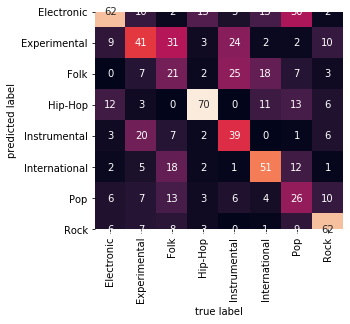

In [335]:
prediction = predict(c_svc, X_test)
mat = confusion_matrix(y_test, prediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
# print(y_test)
# print(prediction)

In [358]:
X_pred = process_for_prediction('000/000010')
y_pred = predict(c_svc, X_pred)
print(y_pred)

[1]


### Support Vector Classification

In [281]:
c_svc = skl.svm.SVC()
train(c_svc, X_train, y_train)

In [282]:
y_pred_train = predict(c_svc, X_train)
y_pred_val = predict(c_svc, X_val)
y_pred_test = predict(c_svc, X_test)
print("SVC - F1 scores:")
print("Train: {:.4f}".format(f1_score(y_train, y_pred_train, average='micro', pos_label=1)))
print("Valid: {:.4f}".format(f1_score(y_val, y_pred_val, average='micro', pos_label=1)))
print("Test: {:.4f}".format(f1_score(y_test, y_pred_test, average='micro', pos_label=1)))

SVC - F1 scores:
Train: 0.7581
Valid: 0.5450
Test: 0.4650


### Random Forests

In [27]:
c_rf = skl.ensemble.RandomForestClassifier(random_state=10, max_depth=30, n_estimators=300, min_samples_leaf=6, min_impurity_decrease=0.0002, 
                                           class_weight='balanced')
train(c_rf, X_train, y_train)

In [28]:
y_pred_train = predict(c_rf, X_train)
y_pred_val = predict(c_rf, X_val)
y_pred_test = predict(c_rf, X_test)
print("Random Forests - F1 scores:")
print("Train: {:.4f}".format(f1_score(y_train, y_pred_train, average='micro', pos_label=1)))
print("Valid: {:.4f}".format(f1_score(y_val, y_pred_val, average='micro', pos_label=1)))
print("Test: {:.4f}".format(f1_score(y_test, y_pred_test, average='micro', pos_label=1)))

Random Forests - F1 scores:
Train: 0.9269
Valid: 0.5238
Test: 0.4175


### Logistic Regression

In [29]:
c_lr = skl.linear_model.LogisticRegression()
train(c_lr, X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [30]:
y_pred_train = predict(c_lr, X_train)
y_pred_val = predict(c_lr, X_val)
y_pred_test = predict(c_lr, X_test)
print("Logistic Regression - F1 scores:")
print("Train: {:.4f}".format(f1_score(y_train, y_pred_train, average='micro', pos_label=1)))
print("Valid: {:.4f}".format(f1_score(y_val, y_pred_val, average='micro', pos_label=1)))
print("Test: {:.4f}".format(f1_score(y_test, y_pred_test, average='micro', pos_label=1)))

Logistic Regression - F1 scores:
Train: 0.5620
Valid: 0.4863
Test: 0.4025


## Deep Learning Models

In [3]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

Using TensorFlow backend.


In [37]:
def dl_predict_raw(data, rate):
    spect = librosa.feature.melspectrogram(y=data, sr=rate,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    spect = spect.T[:640, :]
    X_pred = spect
    X_test_raw = librosa.core.db_to_power(X_pred, ref=1.0)
    X_test_raw = np.log(X_test_raw)
    X_test_exp = np.expand_dims(X_test_raw, axis = -1)
    X_test_exp = np.expand_dims(X_test_exp, axis = 0)
    
    dl_result = model.predict(X_test_exp)
    return dl_result, np.argmax(dl_result, axis = 1)

def dl_predict_by_path(path):
    y, sr = librosa.load(path, duration=30)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    spect = spect.T[:640, :]
    X_pred = spect
    X_test_raw = librosa.core.db_to_power(X_pred, ref=1.0)
    X_test_raw = np.log(X_test_raw)
    X_test_exp = np.expand_dims(X_test_raw, axis = -1)
    X_test_exp = np.expand_dims(X_test_exp, axis = 0)
    
    dl_result = model.predict(X_test_exp)
    return dl_result, np.argmax(dl_result, axis = 1)

def dl_process_by_tid(tid):
    y, sr = librosa.load(get_audio_path(AUDIO_PATH, tid))
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    spect = spect.T[:640, :]
    return spect

def dl_predict_by_tid(model, tid):
    X_pred = dl_process_by_tid(tid)
    X_test_raw = librosa.core.db_to_power(X_pred, ref=1.0)
    X_test_raw = np.log(X_test_raw)
    X_test_exp = np.expand_dims(X_test_raw, axis = -1)
    X_test_exp = np.expand_dims(X_test_exp, axis = 0)
    
    dl_result = model.predict(X_test_exp)
    return dl_result, np.argmax(dl_result, axis = 1)

def dl_predict_by_index(model, tid):
    dl_result = model.predict(X_test_exp[tid:tid+1,:,:,:])
    return dl_result, np.argmax(dl_result, axis = 1)

In [5]:
weights = 'models/prcnn/base-weights.best.h5'
model = load_model(weights)

In [ ]:
attention_weights = './new_attention_weights.best.h5'
attention_model = load_model(attention_weights)

In [6]:
# Testing base test data:
base_npzfile = np.load('base_test_arr.npz')
base_X_test = base_npzfile['arr_0']
base_y_test = base_npzfile['arr_1']
print(base_X_test.shape)
# base_X_test, base_y_test = scale_shuffle_data(base_X_test, base_y_test)

(800, 640, 128)


In [7]:
X_test_raw = librosa.core.db_to_power(base_X_test, ref=1.0)
X_test_raw = np.log(X_test_raw)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

X_test_exp = np.expand_dims(X_test_raw, axis = -1)
y_pred = model.predict(X_test_exp)
y_pred = np.argmax(y_pred, axis = 1)
y_true = base_y_test - 1

-18.420680743952367 1.554312234475218e-15 -10.044188292533065


In [8]:
print(classification_report(y_true, y_pred, target_names=dict_genres.keys()))
print(accuracy_score(y_true, y_pred))

               precision    recall  f1-score   support

   Electronic       0.59      0.51      0.55       100
 Experimental       0.30      0.30      0.30       100
         Folk       0.24      0.28      0.26       100
      Hip-Hop       0.63      0.80      0.70       100
 Instrumental       0.43      0.41      0.42       100
International       0.58      0.45      0.51       100
          Pop       0.26      0.19      0.22       100
         Rock       0.49      0.61      0.54       100

     accuracy                           0.44       800
    macro avg       0.44      0.44      0.44       800
 weighted avg       0.44      0.44      0.44       800

0.44375


### Predictions

In [72]:
# X_pred = dl_process_by_tid(10)
# print(X_pred.shape)
# prob, label = dl_predict_by_index(model, 15)
# print(prob)
# print(label)

# prob, label = dl_predict_by_tid(model, 200)
prob, label = dl_predict_by_path('./demo-test/say-something-do-nothing-rock.mp3')
# print(prob)
# print(label)
topthree = np.argsort(-prob)
print(reverse_map[topthree[0][0]] + ': ' + round((prob[0][topthree[0][0]] * 100), 2).astype('str') + '%, ' 
      + reverse_map[topthree[0][1]] + ': ' + round((prob[0][topthree[0][1]] * 100), 2).astype('str') + '%, ' 
      + reverse_map[topthree[0][2]] + ': ' + round((prob[0][topthree[0][2]] * 100), 2).astype('str') + '%')

0.99999994
[[7 6 3 0 2 1 4 5]]
Rock: 66.68%, Pop: 21.3%, Hip-Hop: 4.77%


## Project Demo

In [80]:
import ipywidgets as widgets
from IPython.display import Audio, display
from IPython import display
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, TwoByTwoLayout, AppLayout

from time import time

In [11]:
chosen_song = ""
output = widgets.Output()

## Custom song upload button
song_upload = widgets.FileUpload(
    accept='',  
    multiple=True, 
    description="Upload Song(s)"
)
display(song_upload)

songs = widgets.Select(
    options=['say-something-do-nothing-rock.mp3', 'traveller-electronic.mp3'],
    rows=6,
    description='Songs:',
    disabled=False
)
display(songs)

# Select model to run on
model_button = widgets.ToggleButtons(
    options=['PRCNN', 'Attention'],
    disabled=False,
    button_style=''
)
display(model_button)

# Run predictions
run_model_button = widgets.Button(
    description='Predict Genre',
    button_style='success',
    icon='check'
)
display(run_model_button, output)

def on_song_upload(change):
    with output:
        new = []
        for i in song_upload.value.keys():
            new.append(i)
        songs.options = list(songs.options) + new

# Run model based on selected song and model
def on_run_model_click(e):
    with output:
        print("====== Predicting Genre with " + str(model_button.value) + " ======")
        
        filename = './demo-test/' + songs.value
        print("Song: " + songs.value)
            
        print("Predicting...")
        start = time()
        prob, label = dl_predict_by_path(filename)
        stop = time()
        
        topthree = np.argsort(-prob)
        print("RESULTS ({:.4f}s): ".format(stop - start))
        print(reverse_map[topthree[0][0]] + ': ' + round((prob[0][topthree[0][0]] * 100), 2).astype('str') + '%, ' 
              + reverse_map[topthree[0][1]] + ': ' + round((prob[0][topthree[0][1]] * 100), 2).astype('str') + '%, ' 
              + reverse_map[topthree[0][2]] + ': ' + round((prob[0][topthree[0][2]] * 100), 2).astype('str') + '%')
        print("")

song_upload.observe(on_song_upload, names='value')
run_model_button.on_click(on_run_model_click)

FileUpload(value={}, description='Upload Song(s)', multiple=True)

Select(description='Songs:', options=('say-something-do-nothing-rock.mp3', 'traveller-electronic.mp3'), rows=6…

ToggleButtons(options=('PRCNN', 'Attention'), value='PRCNN')

Button(button_style='success', description='Predict Genre', icon='check', style=ButtonStyle())

Output()

In [65]:
print(list(dict_genres.keys()))

['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


## Source from Microphone

** Start Recording from Microphone... **
** Recording complete. ** 
Predicting...
RESULTS (0.0685s): 
Folk: 72.4%, International: 12.43%, Experimental: 7.07%



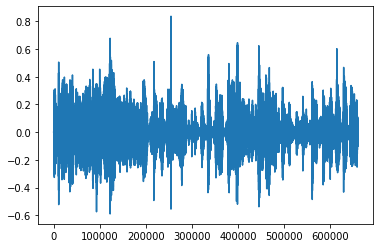

In [84]:
import pyaudio
import numpy as np
import pylab

CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 15

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

frames = []
print("** Start Recording from Microphone... **")
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = np.frombuffer(stream.read(CHUNK),dtype=np.float32)
    frames.append(data)
print("** Recording complete. ** ")
frames = np.array(frames).flatten()
stream.stop_stream()
stream.close()
p.terminate()

plt.plot(frames)

print("Predicting...")
start = time()
prob, label = dl_predict_raw(frames, RATE)
stop = time()

topthree = np.argsort(-prob)
print("RESULTS ({:.4f}s): ".format(stop - start))
print(reverse_map[topthree[0][0]] + ': ' + round((prob[0][topthree[0][0]] * 100), 2).astype('str') + '%, ' 
      + reverse_map[topthree[0][1]] + ': ' + round((prob[0][topthree[0][1]] * 100), 2).astype('str') + '%, ' 
      + reverse_map[topthree[0][2]] + ': ' + round((prob[0][topthree[0][2]] * 100), 2).astype('str') + '%')
print("")

display.Audio(frames, rate=RATE)